In [205]:
# import required packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy import signal
from scipy import linalg
from lib.cutter import Cutter

In [206]:
# get data from peter
cutter = Cutter("data")

In [207]:
# get example dataframe
gen = cutter.get_gen()
df = next(gen)
df.head()


,rtctime,lat,lon,target_temperature,feature_c,feature_ct,feature_motorspeed,ambient_temp,car_speed,soc,rtc_gap,is_track_beginning,track_id
0,1672911588170,68.860123,18.346718,-4.281718,20.947325,-1.0,68.902439,-3.9,1.05,84.199997,NaN,1,1
1,1672911588180,68.860123,18.346718,-4.281718,20.947325,-1.0,68.902439,-3.9,1.05,84.199997,NaN,0,1
2,1672911588190,68.860123,18.346718,-4.281718,20.947325,-1.0,68.902439,-3.9,1.05,84.199997,NaN,0,1
3,1672911588200,68.860123,18.346718,-4.281718,21.361129,-1.0,70.731707,-3.9,1.05,84.199997,NaN,0,1
4,1672911588210,68.860123,18.346718,-4.281718,21.361129,-1.0,70.731707,-3.9,1.11,84.199997,NaN,0,1


In [208]:
df = df.iloc[-1000000:]

In [209]:
w = 10000
conv_c = signal.convolve(df["feature_c"], np.ones(w), 'valid') / w
conv_target = signal.convolve(df["target_temperature"], np.ones(w), 'valid') / w
df = df.iloc[w-1:]
df["feature_c"] = conv_c
df["target_temperature"] = conv_target

[]

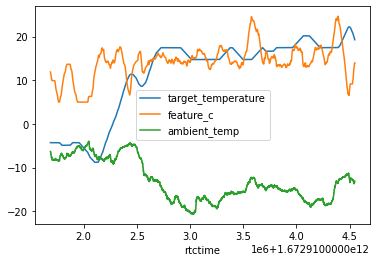

In [210]:
df.plot(x="rtctime", y=["target_temperature", "feature_c", "ambient_temp"]) #y=["target_temperature", "ambient_temp", "car_speed", "feature_c"])
plt.plot()

In [211]:
f_target = interp1d(df["rtctime"], df["target_temperature"], kind="linear")
f_c = interp1d(df["rtctime"], df["feature_c"], kind="linear")
f_ambient = interp1d(df["rtctime"], df["ambient_temp"], kind="linear")

In [212]:
#a = np.array(df["ambient_temp"])[:-1]
#s = np.array(df["feature_c"])[:-1]
#y = np.array(df["target_temperature"])[:-1]
#z = np.array(df["target_temperature"])[1:]

t = np.array(df["rtctime"])
a = f_ambient(t)
s = f_c(t)
y = f_target(t)
#z = f_target(t)[1:]

ay = a - y

ay2 = ay @ ay
ays = ay @ s
s2 = s @ s
ayz = ay @ y
sz = s @ y

A = 10 * np.array([[ay2, ays], [ays, s2]])
b = np.array([ayz, sz])

c = -linalg.solve(A, b, assume_a='sym')
print(c)

[0.06790422 0.03422103]


In [213]:
C1, C2 = 0.0002, 0.0005
#C1, C2 = c

# function defining the ode
def odefun(t, target_temp):
    val = C1 * (f_ambient(t) - target_temp) + C2 * f_c(t)
    return val

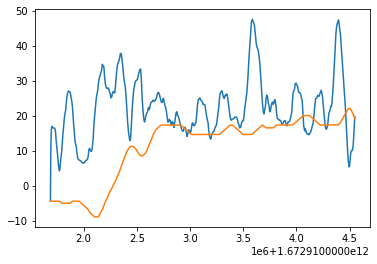

In [214]:
sol = solve_ivp(fun=odefun, t_span=[df.iloc[0]["rtctime"], df.iloc[-1]["rtctime"]], y0=[df.iloc[0]["target_temperature"]])
plt.plot(sol.t, sol.y.T)
plt.plot(df["rtctime"], df["target_temperature"])
plt.show()
